In [124]:
import PyPDF2
from PyPDF2 import PdfFileReader, PdfFileWriter
from pdf2image import convert_from_path
import PIL
from PIL import Image, ImageFilter
from wand.image import Image as Img
import os
import os.path
from PIL import Image
import pyocr
import pyocr.builders
from PIL import Image
import subprocess
import pandas as pd
import sys
import scipy.misc
tools = pyocr.get_available_tools()[0]
# The tools are returned in the recommended order of usage

langs = tools.get_available_languages()
lang = langs[0]
print(lang)


eng


In [24]:
"""
pdfFileObj = open("filled_koa-ca-1.pdf", 'rb') 
pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
pageObj = pdfReader.getPage(5)
writer = PdfFileWriter()

pageObj.cropBox.lowerLeft = (0,0)
pageObj.cropBox.upperRight = (560, 920)

writer.addPage(pageObj)
outstream = open("pageFive" + ".pdf", 'wb')
writer.write(outstream)
outstream.close()
with Img(filename= "pageFive" + ".pdf", resolution=300) as img:   # convert pdf to jpg
    img.compression_quality = 99 
    img.save(filename= "pageFive" + ".png")

    
bashCommand = """gsutil cp pageFive.png""" # output file
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
#output, error = process.communicate()
#subprocess.run(["pwd"])
#bashCommand = "gsutil cp " + os.path.dirname(os.path.abspath("pageFive.png")) + " gs://gato365packets"
#process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
"""

SyntaxError: invalid syntax (<ipython-input-24-2e0f1c01d72b>, line 19)

In [25]:
###############################################################################
# Main logic for making directories of student answers
# The code takes in the packet of scanned answers and then 
# sorts the worksheets based on worksheet name and student name
#
# Student answers are then placed into their own subdirectory
###############################################################################

def getAnswers(pdfPacketName):
    
    sheet_id = []; name_id = []
    pdfFileObj = open(pdfPacketName, 'rb') 
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    print(pdfReader.numPages)
        
    for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i)

        pdfToPNG(pageObj, "identifier", (29, 740), (31 + 65, 745 + 26))
        
        
        ###############################################################################
        # This line of code processes the worksheet name
        # It takes the PNG rectangle box, lightens the 
        # rectangle box around the sheet name, and then 
        # darkens the actual characters
        # S.L. 7/18/19
        ###############################################################################
        bashCommand = """convert identifier.png -type Grayscale -negate -define morphology:compose=darken -morphology Thinning 'Rectangle:1x80+0+0<' -negate out.png""" # output file
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        ###############################################################################

        worksheetName = tools.image_to_string(Image.open('identifier.png'), 
                                     builder=pyocr.builders.DigitBuilder())

        # Create worksheet directory if it doesn't exist
        if not os.path.exists(worksheetName):
            os.makedirs(worksheetName)
            
        pageObj = pdfReader.getPage(i)
        writer = PdfFileWriter()
        
        pdfToPNG(pageObj, "student", (200, 739), (282, 775))

        studentName = tools.image_to_string(Image.open('student.png'), 
                                     builder=pyocr.builders.DigitBuilder())
        print(studentName)
        name_id.append(studentName)
        sheet_id.append(worksheetName)
        pathName = worksheetName + "/" + studentName
        print(pathName)

        if not os.path.exists(pathName):
            os.makedirs(pathName)

        df = pd.read_csv('points.csv')

        #df['Koa-CA-1'].str.split(';')
        #for row in df.itertuples(index=True, name='Pandas'):
        #    print getattr(row, "c1"), getattr(row, "c2")
        #print(df)
        matrix = [list(l) for l in zip(*df.values)]

        getAttribute(pageObj, pathName, worksheetName, matrix, pdfPacketName)
    close(pdfPacketName)



In [26]:
#################################################################
# outputName is the filename minus extension
# Usage: pdfToJPG(pageObj, identifier, (x, y), (x, y))
# this will create crop the pdf and creater identifier.jpg at
# the given coordinates
# TODO: pdfToPNG is a kind of inefficient function to keep calling
# A future improvement would just be converting to PNG once and then
# cropping, instead of converting pdf to png for each crop box
# S.L. 7/18/19
#################################################################

def pdfToPNG(pageObj, fileName, bottomLeft, upperRight):

    writer = PdfFileWriter()

    pageObj.cropBox.lowerLeft = bottomLeft
    pageObj.cropBox.upperRight = upperRight

    writer.addPage(pageObj)
    outstream = open(fileName + ".pdf", 'wb')
    writer.write(outstream)
    outstream.close()
    with Img(filename= fileName + ".pdf", resolution=300) as img:   # convert pdf to jpg
        img.compression_quality = 99 
        img.save(filename= fileName + ".png")
    img = Image.open(fileName + '.png')
    crop_img = img.crop((bottomLeft[0] / 72 * 300, (11 - (upperRight[1] / 72)) * 300, upperRight[0] / 72 * 300, (11 - (bottomLeft[1] / 72)) * 300))
    crop_img.save(fileName + '.png')
    os.remove(fileName + ".pdf")
    #img = Image.open(fileName + ".png")
    #img = img.convert('L')
    #img = img.crop
    #img.save(fileName + ".png")

In [27]:
#################################################################
# getAttribute takes in a pageobject, pathname, and a dataframe
# and writes the individual student answers in the corresponding
# directory. Note: reliability depends on reading the correct
# worksheet name and student ID. 
# S.L. 7/18/19
#################################################################

def getAttribute(pageObj, pathName, worksheetName, matrix, pdfPacketName):
    
    df = pd.read_csv('points.csv')
    
    matrix = [list(l) for l in zip(*df.values)]
    try:
        pointsList = df[worksheetName]
    except:
        print("Error: The CSV file does not contain points that correspond to the worksheet name - " + worksheetName)
        print("This can occur when the program misreads the worksheet name from the PDF file.")
        print("Note - This error means that an invalid directory has also been created in the top level.")
        pathName = input("""Please enter the correct pathname in the format \(Worksheet Name\/Student Name if known\), or
        type 'quit' to stop the kernel""")
        
        if pathName == 'quit':
            close(pdfPacketName)
            sys.exit(1)
        else:
            if not os.path.exists(pathName):
                os.makedirs(pathName)
            worksheetName = pathName.split("/")[0]
            
            pointsList = df[worksheetName]
    #colIndex = df.columns.get_loc(worksheetName)
     
    for i in range(len(pointsList)):
        
        bottomLeft = getCorner(pointsList[i])
        #print(bottomLeft)
        topRight = getSides(bottomLeft, pointsList[i])
        problemNumber = getProblemNumber(pointsList[i])
        #print(topRight)
        pdfToPNG(pageObj, pathName + "/" + problemNumber, bottomLeft, topRight)

In [7]:
#def getAnswer(pathname, bottomLeft, topRight):
    

In [8]:
def getCorner(string): 
    #print(string[3:19])
    bl = string.split("; size-")[0].split("BL-")[1].split(",")
    return (((float(bl[0][1:]))) * 72, (11 - float(bl[1][:len(bl[1]) - 1])) * 72)

In [9]:
def getSides(bottomLeft, string):
    string = string.split("; size-")[1].split(",")
    #print(string)
    return((bottomLeft[0] + 72 * float(string[0][1:])), (bottomLeft[1] + 72 * float(string[1][:len(string[1]) - 1])))
    
    

In [10]:
def getProblemNumber(string):
    return string.split(";")[2].strip()

In [10]:
import pandas as pd

getAnswers("filled_koa-ca-1.pdf")

25


FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [16]:
import xlwt
xCell = 0
yCell = 0
book = xlwt.Workbook()
sh = book.add_sheet("answers")
book.save("trial.xls")

In [17]:
def imcrop_tosquare(img):
    """Make any image a square image.

    Parameters
    ----------
    img : np.ndarray
        Input image to crop, assumed at least 2d.

    Returns
    -------
    crop : np.ndarray
        Cropped image.
    """
    if img.shape[0] > img.shape[1]:
        extra = (img.shape[0] - img.shape[1])
        if extra % 2 == 0:
            crop = img[extra // 2:-extra // 2, :]
        else:
            crop = img[max(0, extra // 2 + 1):min(-1, -(extra // 2)), :]
    elif img.shape[1] > img.shape[0]:
        extra = (img.shape[1] - img.shape[0])
        if extra % 2 == 0:
            crop = img[:, extra // 2:-extra // 2]
        else:
            crop = img[:, max(0, extra // 2 + 1):min(-1, -(extra // 2))]
    else:
        crop = img
    return crop

In [18]:
def imcrop(img, amt):
    if amt <= 0 or amt >= 1:
        return img
    row_i = int(img.shape[0] * amt) // 2
    col_i = int(img.shape[1] * amt) // 2
    return img[row_i:-row_i, col_i:-col_i]

In [19]:
from scipy.misc import imresize
imresize?

`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead. [ipykernel_launcher.py:7]


[[[247 247 247 255]
  [253 253 253 255]
  [255 255 255 255]
  ...
  [255 255 255 255]
  [255 255 255 255]
  [255 255 255 255]]

 [[255 255 255 255]
  [246 246 246 255]
  [250 250 250 255]
  ...
  [251 251 251 255]
  [231 231 231 255]
  [247 247 247 255]]

 [[255 255 255 255]
  [223 223 223 255]
  [231 231 231 255]
  ...
  [218 218 218 255]
  [193 193 193 255]
  [238 238 238 255]]

 ...

 [[255 255 255 255]
  [247 247 247 255]
  [245 245 245 255]
  ...
  [246 246 246 255]
  [228 228 228 255]
  [230 230 230 255]]

 [[246 246 246 255]
  [246 246 246 255]
  [248 248 248 255]
  ...
  [240 240 240 255]
  [230 230 230 255]
  [235 235 235 255]]

 [[238 238 238 255]
  [234 234 234 255]
  [227 227 227 255]
  ...
  [254 254 254 255]
  [254 254 254 255]
  [254 254 254 255]]]


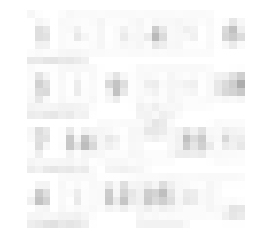

In [128]:
import matplotlib.pyplot as plt
import numpy as np
img = plt.imread("pageOne.png")
plt.axis('off')
square = imcrop_tosquare(img)
crop = imcrop(square, 0.2)
rsz = imresize(crop, (28, 28))
print(rsz)

plt.imshow(rsz)
plt.savefig("test.png", bbox_inches='tight', pad_inches=0)


#img = Image.open("test.png").convert('LA')

#plt.imshow("test.png", cmap='gray')
#print(img.shape)

#I = np.asarray(PIL.Image.open('test.png'))
#im = PIL.Image.fromarray(np.uint8(I))
#print(im)
#img.save("test.png")
#img = plt.imread("test.png")
#img = plt.imread("test.png")
#crop = imcrop(square, 0.2)
#rsz = imresize(crop, (28, 28))


`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead. [ipykernel_launcher.py:7]


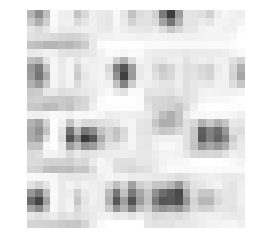

In [141]:
plt.axis('off')
img = plt.imread("test.png")
#plt.imshow(img)
square = imcrop_tosquare(img)
crop = imcrop(square, 0.2)
rsz = imresize(crop, (28, 28))
#plt.imshow(rsz)

#print(rsz)
intensity = rsz.sum(axis=2) // 4
intensity.shape
f=open('test.csv','ab')
np.savetxt(f, intensity, delimiter=",", fmt='%s', header = 'fuck')
f.close()

#print(intensity)
plt.imshow(rsz)


#plt.savefig("test.png")
#np.savetxt("test.csv", rsz, delimiter=",")

In [145]:
def resizeAndExport(imageName, npArray, outputName):
    plt.axis('off')
    img = plt.imread(imageName)
    square = imcrop_tosquare(img)
    crop = imcrop(square, 0.2)
    rsz = imresize(crop, (28, 28))

    intensity = rsz.sum(axis=2) // 4

    f=open('test.csv','ab')
    np.savetxt(f, intensity, delimiter=",", fmt='%s', header = outputName)
    f.close()
    
    